<a href="https://www.kaggle.com/code/aleksandrmorozov123/time-series-forecasting-with-python?scriptVersionId=100625118" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


**Code partially taken from the book - "Machine learning for time series" by Francesca Lazzeri. Code
https://github.com/FrancescaLazzeri/Machine-Learning-for-Time-Series-Forecasting**

# **First step - exploratory data analisys**

**Import required libraries**

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import warnings
from collections import UserDict
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
%matplotlib inline
import matplotlib.dates as mpl_dates
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import math
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

**Read the datasets**

In [3]:
holiday = pd.read_csv ('../input/store-sales-time-series-forecasting/holidays_events.csv')
holiday.head (10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [4]:
oil = pd.read_csv ('../input/store-sales-time-series-forecasting/oil.csv')
oil.head (10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [5]:
stores = pd.read_csv ('../input/store-sales-time-series-forecasting/stores.csv')
stores.head (10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [6]:
transactions = pd.read_csv ('../input/store-sales-time-series-forecasting/transactions.csv')
transactions.head (10)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


**Check the rows with empty values**

In [7]:
holiday.isna ().sum ()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [8]:
oil.isna ().sum ()

date           0
dcoilwtico    43
dtype: int64

In [9]:
# drop the missing values
oil = oil.dropna ()
oil.count ()

date          1175
dcoilwtico    1175
dtype: int64

In [10]:
stores.isna ().sum ()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [11]:
transactions.isna ().sum ()

date            0
store_nbr       0
transactions    0
dtype: int64

**We transform the data into a date series format, since only in this way it will be possible to process the data**

In [12]:
# convert datasets to time series
holiday ['date'] = pd.to_datetime(holiday['date']) 
oil ['date'] = pd.to_datetime(oil ['date'])
transactions ['date'] = pd.to_datetime(transactions ['date']) 

In [13]:
holiday.describe(include=[object])  

,type,locale,locale_name,description
count,350,350,350,350
unique,6,3,24,103
top,Holiday,National,Ecuador,Carnaval
freq,221,174,174,10


In [14]:
stores.describe(include=[object])  

,city,state,type
count,54,54,54
unique,22,16,5
top,Quito,Pichincha,D
freq,18,19,18


**Create a lag plot for datasets. Lag plots are used to check if a time series is random: random data should not exhibit any structure in the lag plot**

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

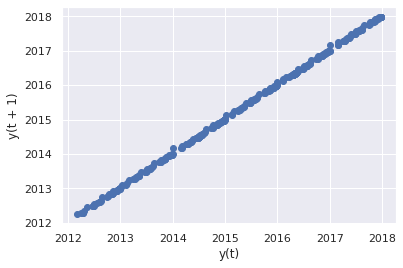

In [15]:
pd.options.display.float_format = "{:, .2f}".format
np.set_printoptions (precision = 2)
warnings.filterwarnings ("ignore")

# import lag_plot function
from pandas.plotting import lag_plot
sns.set ()

# pass the lag argument and plot the values
# when lag = 1 the plot is essentially data [:-1] vs. data [1:]
# plot our holiday data set
lag_plot (holiday ['date'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

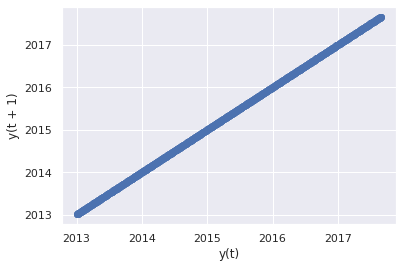

In [16]:
# plot our oil data set
lag_plot (oil ['date'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

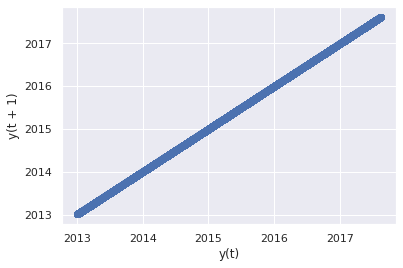

In [17]:
# plot our transactions data set
lag_plot (transactions ['date'])

*As we can see, the data has a clear linear structure.*

**Create an autocorrelation plot for datasets. Autocorrelation plots applied to check randomness in time series by computing autocorrelations for data values at fluctuating time lags. It is heavily used in time series analysis and forecasting. We can calculate the correlation for current time-series observations with observations of previous time steps called lags.**

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

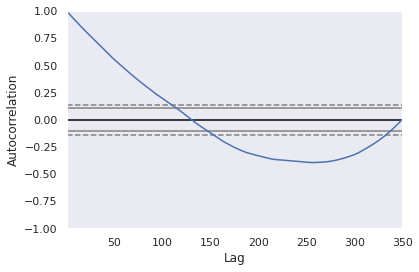

In [18]:
# import autocorrelation plot function
from pandas.plotting import autocorrelation_plot
sns.set ()

# pass the autocorrelation argument and plot the values holiday
holiday.reset_index(inplace=True)
holiday ['date'] = holiday ['date'].apply(mpl_dates.date2num)
holiday ['date'] = holiday ['date'].astype(float)
autocorrelation_plot (holiday ['date'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

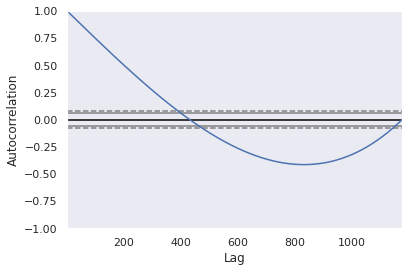

In [19]:
# pass the autocorrelation argument and plot the values oil
oil.reset_index(inplace=True)
oil ['date'] = oil ['date'].apply(mpl_dates.date2num)
oil ['date'] = oil ['date'].astype(float)
autocorrelation_plot (oil ['date'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

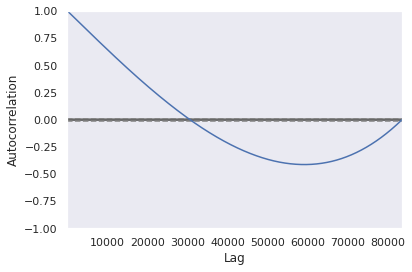

In [20]:
# pass the autocorrelation argument and plot the values transactions
transactions.reset_index(inplace=True)
transactions ['date'] = transactions ['date'].apply(mpl_dates.date2num)
transactions ['date'] = transactions ['date'].astype(float)
autocorrelation_plot (transactions ['date'])

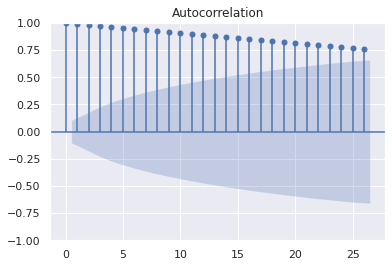

In [21]:
# import plot_acf () function
from statsmodels.graphics.tsaplots import plot_acf

# plot the acf function on the holiday data set
plot_acf (holiday ['date'])
plt.show ()

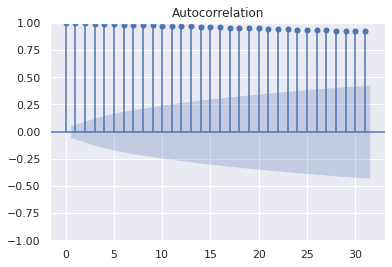

In [22]:
# plot the acf function for oil data set
plot_acf (oil ['date'])
plt.show ()

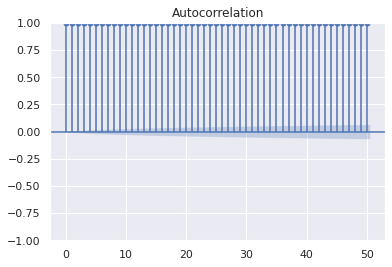

In [23]:
# plot the acf function for transactions data set
plot_acf (transactions ['date'])
plt.show ()

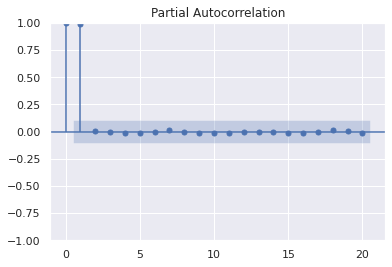

In [24]:
# import plor_pacf () function
from statsmodels.graphics.tsaplots import plot_pacf

# plot the pacf fucntion on the holiday dataset
plot_pacf (holiday ['date'], lags = 20)
plt.show ()

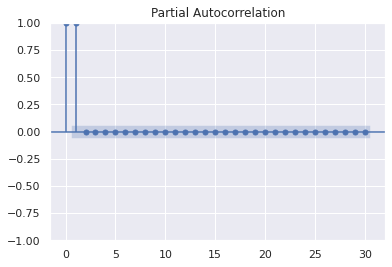

In [25]:
# plot the pacf function on the oil dataset
plot_pacf (oil ['date'], lags = 30)
plt.show ()

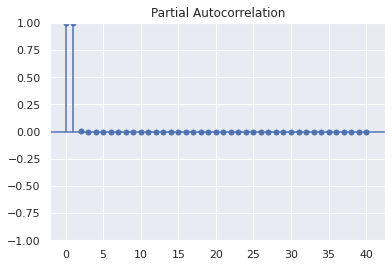

In [26]:
# plot the pacf function on the transactions dataset
plot_pacf (transactions ['date'], lags = 40)
plt.show ()

**Autoregression modeling. 
Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems.**

In [27]:
# apply AutoReg model for holiday dataset
modelH = AutoReg (oil ['date'], 1)
resultsH = modelH.fit ()
resultsH.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   date   No. Observations:                 1175
Model:                     AutoReg(1)   Log Likelihood               -1516.654
Method:               Conditional MLE   S.D. of innovations              0.881
Date:                Tue, 12 Jul 2022   AIC                           3039.308
Time:                        09:58:29   BIC                           3054.512
Sample:                             1   HQIC                          3045.041
                                 1175                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4525      0.866      1.677      0.094      -0.245       3.150
date.L1        1.0000   5.23e-05   1.91e+04      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [28]:
# apply AutoReg model for oil dataset
modelO = AutoReg (oil ['date'], 1)
resultsO = modelO.fit ()
resultsO.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   date   No. Observations:                 1175
Model:                     AutoReg(1)   Log Likelihood               -1516.654
Method:               Conditional MLE   S.D. of innovations              0.881
Date:                Tue, 12 Jul 2022   AIC                           3039.308
Time:                        09:58:29   BIC                           3054.512
Sample:                             1   HQIC                          3045.041
                                 1175                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4525      0.866      1.677      0.094      -0.245       3.150
date.L1        1.0000   5.23e-05   1.91e+04      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
# apply AutoReg model for transactions dataset
modelT = AutoReg (transactions ['date'], 1)
resultsT = modelT.fit ()
resultsT.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   date   No. Observations:                83488
Model:                     AutoReg(1)   Log Likelihood               44962.067
Method:               Conditional MLE   S.D. of innovations              0.141
Date:                Tue, 12 Jul 2022   AIC                         -89918.135
Time:                        09:58:29   BIC                         -89890.137
Sample:                             1   HQIC                        -89909.569
                                83488                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0579      0.017      3.477      0.001       0.025       0.090
date.L1        1.0000      1e-06   9.97e+05      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

**Visualize the forecasts**

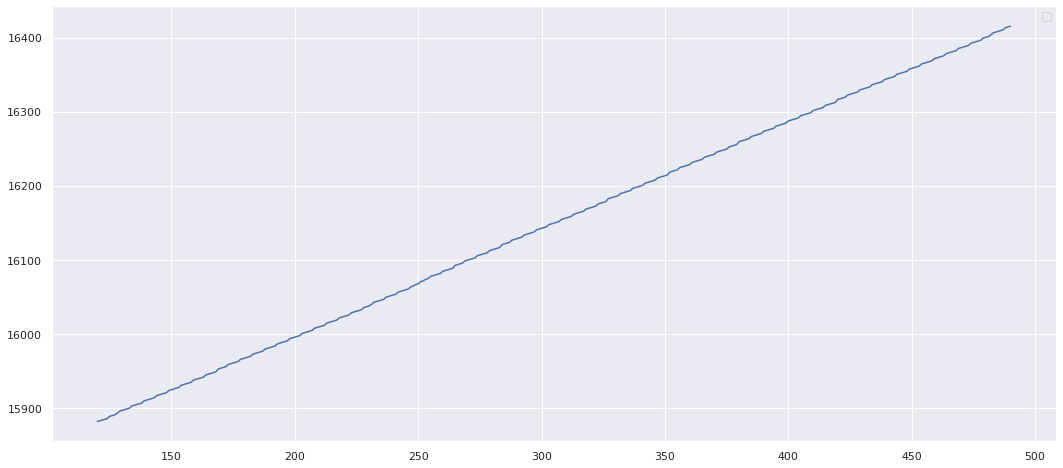

In [30]:
# define figure style, plot package and default figure size
sns.set_style ('darkgrid')
pd.plotting.register_matplotlib_converters ()

# default figure size
sns.mpl.rc ('figure', figsize = (18, 8))

# use plot_predict and visualize forecasts for holiday dataset
figure = resultsH.plot_predict (120, 490)

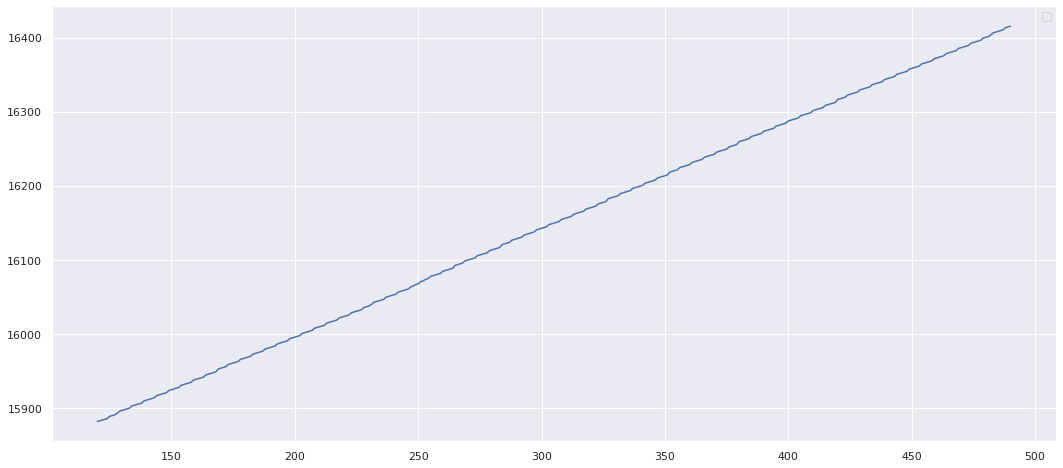

In [31]:
# use plot_predict and visualize forecasts for oil dataset
figure = resultsO.plot_predict (120, 490)

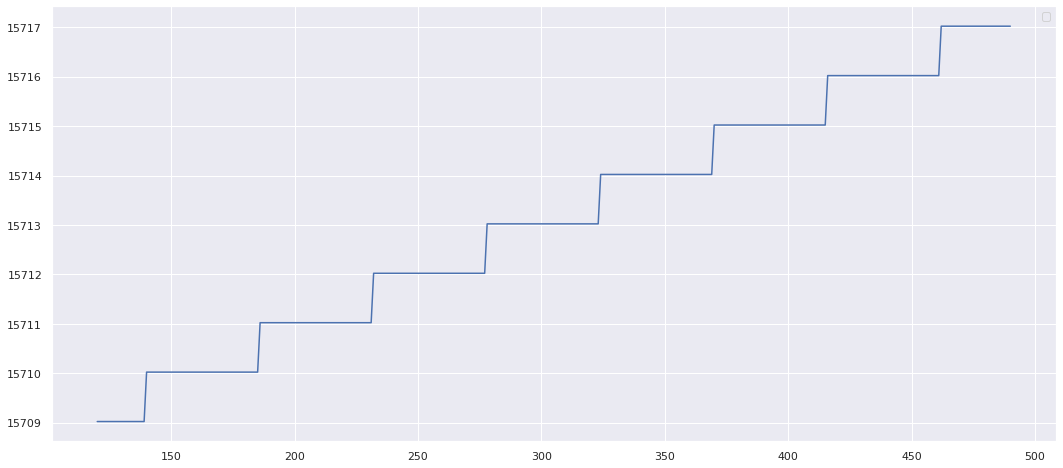

In [32]:
# results plot_predict and visualize forecasts for transactions dataset
figure = resultsT.plot_predict (120, 490)

**Plot_diagnostics indicates that the model captures the key features in the data. They help us determine visually how our model is fitting the data and if any of the basic assumptions of an OLS (ordinary least squares) model are being violated.**

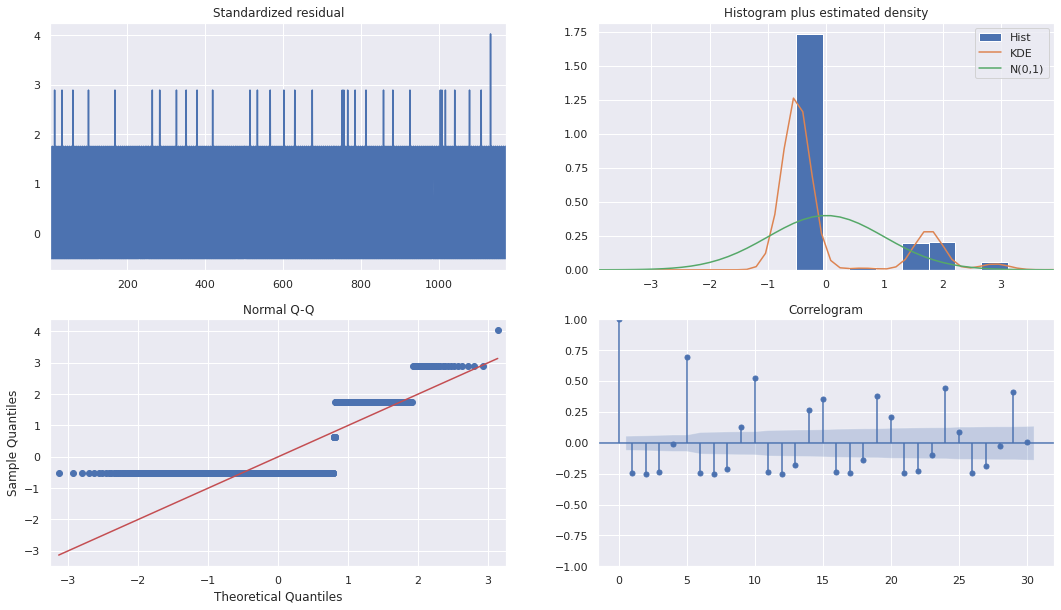

In [33]:
# define default figure size
fig = plt.figure (figsize = (18, 10))

# use plot_predict and visualize forecasts for holiday dataset
fig = resultsH.plot_diagnostics (fig = fig, lags = 30)

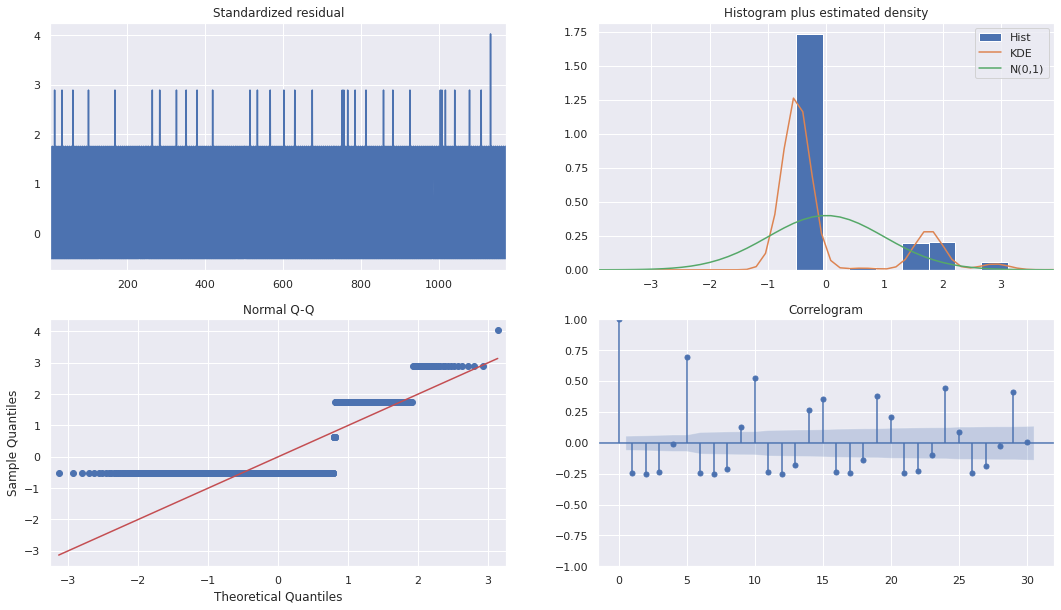

In [34]:
# define default figure size
fig = plt.figure (figsize = (18, 10))

# use plot_predict and visualize forecasts for oil dataset
fig = resultsO.plot_diagnostics (fig = fig, lags = 30)

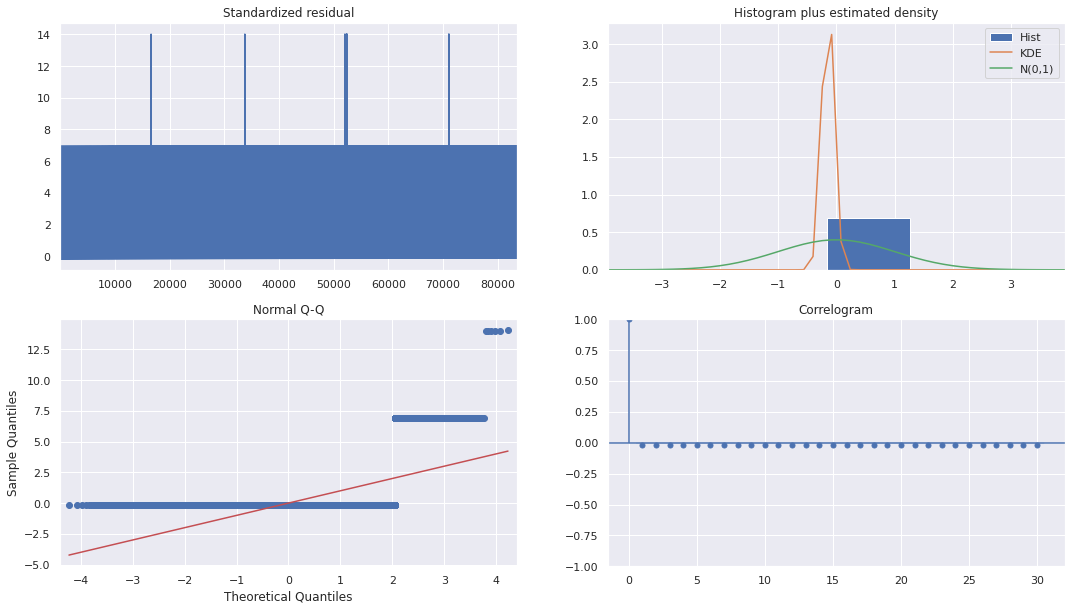

In [35]:
# define default figure size
fig = plt.figure (figsize = (18, 10))

# use plot_predict and visualize forecasts for oil dataset
fig = resultsT.plot_diagnostics (fig = fig, lags = 30)

**Training the model for oil dataset**

In [36]:
from sklearn.model_selection import train_test_split
# create train set containing only the model features
X = oil

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

print ('Training data shape X: ', X_train.shape)
print ('Test data shape X: ', X_test.shape)

Training data shape X:  (787, 3)
Test data shape X:  (388, 3)


In [37]:
# scale train data to be in range (0, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler ()
X_train = scaler.fit_transform (X_train)

# scale test data to be in range (0, 1)
X_test = scaler.transform (X_test)

# specify the number of steps to forecast ahead
HORIZON = 3
print ('Forecasting horizon: ', HORIZON, 'days')

Forecasting horizon:  3 days


In [38]:
# make predictions on the test data
training_window = 720

history = [x for x in X_train]
history = history [(-training_window):]
predictions = list ()

for t in range (X_test.shape [0]):
    modelO = AutoReg (oil ['date'], 1)
    modelO_fit = modelH.fit ()
    yhat = modelO_fit.predict
    predictions.append (yhat)
    obs = list (X_test [t])
    # move the trainig window
    history.append (obs [0])
    history.pop (0)
    print (X_test [t])
    print (t+1, ': predicted =', yhat, 'expected =', obs)

[0.56 0.56 0.18]
1 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7f9dad55fbd0>> expected = [0.562962962962963, 0.5631981187536734, 0.18103033220991815]
[0.36 0.36 0.78]
2 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7f9dad55fd10>> expected = [0.36378600823045265, 0.3633156966490301, 0.7780452575830524]
[0.16 0.16 0.91]
3 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7f9dad55fcd0>> expected = [0.16296296296296295, 0.16343327454438494, 0.90912373615792]
[0.18 0.18 0.83]
4 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x7f9dad55fc10>> expected = [0.17695473251028807, 0.17695473251028737, 0.8337746750120366]
[0.63 0.63 0.12]
5 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrap

**Deep learning for time series forecasting**

In [39]:
# read the data
X = pd.read_csv ('../input/store-sales-time-series-forecasting/test.csv')
y = pd.read_csv ('../input/store-sales-time-series-forecasting/train.csv')

# sampling the data in X
X = X ['date'].sample(5000)

# sampling the data in y
y = y ['date'].sample (5000)

In [40]:
# setting T - the number of lag variables 
T = 1

# setting the horizon, as we interesting in predicting next day
HORIZON = 1

In [41]:
# convert datasets to time series
X = pd.to_datetime(X) 
y = pd.to_datetime(y)

In [42]:
# create train set containing only the model features
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print ('Training data shape X: ', X_train.shape)
print ('Test data shape X: ', X_test.shape)
print ('Training data shape y: ', y_train.shape)
print ('Test data shape y: ', y_test.shape)

Training data shape X:  (2500,)
Test data shape X:  (2500,)
Training data shape y:  (2500,)
Test data shape y:  (2500,)


In [43]:
# create a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.5)

print ('Validation data shape X: ', X_valid.shape)
print ('Validation data shape y: ', y_valid.shape)

Validation data shape X:  (1250,)
Validation data shape y:  (1250,)


In [44]:
# converting data
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
X_valid = np.asarray (X_valid).astype (np.float32)
y_valid = np.asarray (y_valid).astype (np.float32)

In [45]:
# rescale the data to 0-1 scale
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = min_max_scaler.fit_transform(X_train.reshape(-1, 1))
y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1)) 
X_test = min_max_scaler.fit_transform(X_test.reshape(-1, 1))
y_test = min_max_scaler.fit_transform(y_test.reshape(-1, 1))
X_valid = min_max_scaler.fit_transform(X_valid.reshape(-1, 1))
y_valid = min_max_scaler.fit_transform(y_valid.reshape(-1, 1))

In [46]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], T, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], T, y_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], T, X_test.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], T, y_test.shape[1]))
X_valid = np.reshape(X_valid, (X_valid.shape[0], T, X_valid.shape[1]))
y_valid = np.reshape(y_valid, (y_valid.shape[0], T, y_valid.shape[1]))

**Univariate models**

In [47]:
# number of units in the RNN layer
LATENT_DIM = 5  

# number of samples per mini-batch
BATCH_SIZE = 32

# maximum number of times the training algorithm will cycle through all samples
EPOCHS = 15

# define model and create a Sequential model
model = Sequential ()
model.add (GRU (LATENT_DIM, input_shape = (T, 1)))
model.add (Dense (HORIZON))

model.compile (optimizer = 'RMSprop', loss = 'mse')
model.summary ()

2022-07-12 09:58:41.021327: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [48]:
# specify early stop criteria
GRU_earlystop = EarlyStopping (monitor = 'val_loss', min_delta = 0, patience = 5)

# fit our model
history = model.fit (X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_valid, y_valid),
                           callbacks = [GRU_earlystop], verbose = 1)

Epoch 1/15


2022-07-12 09:58:41.719836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


40/40 [==============================] - 3s 16ms/step - loss: 0.2410 - val_loss: 0.1872
Epoch 2/15
40/40 [==============================] - 0s 4ms/step - loss: 0.1493 - val_loss: 0.1255
Epoch 3/15
40/40 [==============================] - 0s 4ms/step - loss: 0.1069 - val_loss: 0.1047
Epoch 4/15
40/40 [==============================] - 0s 4ms/step - loss: 0.0989 - val_loss: 0.1036
Epoch 5/15
40/40 [==============================] - 0s 4ms/step - loss: 0.0977 - val_loss: 0.1022
Epoch 6/15
40/40 [==============================] - 0s 4ms/step - loss: 0.0966 - val_loss: 0.1013
Epoch 7/15
40/40 [==============================] - 0s 4ms/step - loss: 0.0960 - val_loss: 0.1005
Epoch 8/15
40/40 [==============================] - 0s 4ms/step - loss: 0.0954 - val_loss: 0.1002
Epoch 9/15
40/40 [==============================] - 0s 4ms/step - loss: 0.0949 - val_loss: 0.0996
Epoch 10/15
40/40 [==============================] - 0s 4ms/step - loss: 0.0946 - val_loss: 0.0994
Epoch 11/15
40/40 [==========

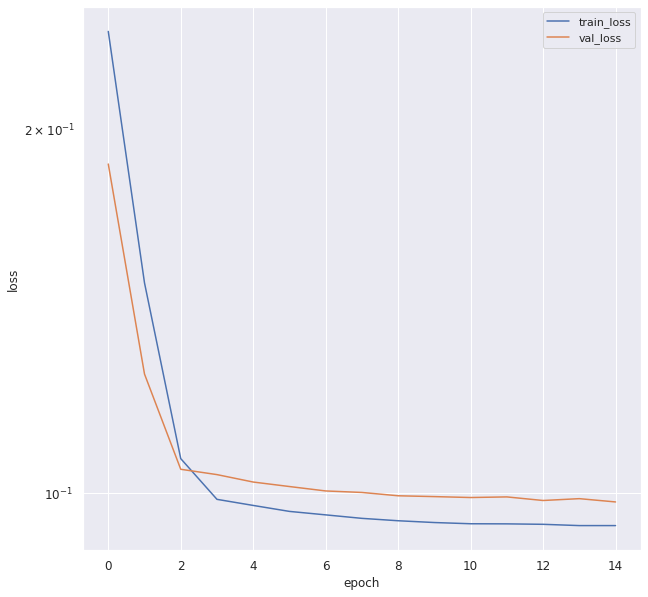

In [49]:
# plot the epochs and train_loss and val_loss
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

*The number of losses decreases with increasing epochs*

In [50]:
# make the predictiondson the X_test and compare those predictions on the y_test
ts_predictions = model.predict (X_test)
ev_ts_data = pd.DataFrame (ts_predictions)
ev_ts_data ['prediction' ]= pd.DataFrame (ts_predictions)
ev_ts_data ['actual'] = np.transpose (y_test).ravel ()

# evaluate our model and compute MAPE (mean absolute percentage error)  
def mape (ts_predictions, actuals):
    return ((ts_predictions - actuals).abs () / actuals).mean ()

mape (ev_ts_data ['prediction'], ev_ts_data ['actual'])

inf

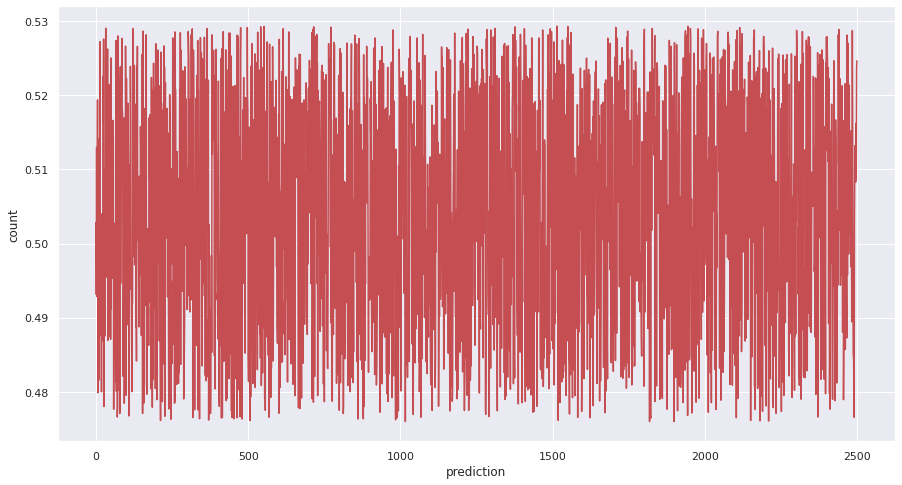

In [51]:
# plot the count of predictions
ev_ts_data ['actual' < '0.3'].plot (x = 'prediction', style = ['r', 'b'], figsize = (15, 8))
plt.xlabel ('prediction', fontsize = 12)
plt.ylabel ('count', fontsize = 12)
plt.show ()